# Clasificación Wildlife
*Sacbe García, Geraldine Gonzales*

# Librerías

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os
import pathlib
import matplotlib.image as mpimg
import random
import numpy as np
from pathlib import Path
import pandas as pd
import zipfile

%matplotlib inline

In [ ]:
!git clone https://github.com/davda54/sam
#!rm -rf sam

Cloning into 'sam'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 200 (delta 73), reused 63 (delta 57), pack-reused 104
Receiving objects: 100% (200/200), 659.65 KiB | 7.25 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
%%writefile /content/sam/__init__.py

Writing /content/sam/__init__.py


# Carga de datos

In [ ]:
import platform
if platform.system() == 'Darwin': #si es macOS
    av1 = torch.backends.mps.is_available()
    # this ensures that the current PyTorch installation was built with MPS activated.
    av2 = torch.backends.mps.is_built()
    if(av1==av2==True):
        print('MPS available?',av1,'MPS built?',av2)
        device = torch.device('mps')
    else:
          device = torch.device('cpu')
else:
    #Check if GPU is available
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print("Device:",device)

Device: cpu


In [ ]:
pathlib.Path.cwd()
!mkdir wildlife_subset

with zipfile.ZipFile('/content/drive/MyDrive/wildlife_subset.zip', 'r') as zip_ref:
    zip_ref.extractall('wildlife_subset')

new_path = "/content/wildlife_subset/wildlife"

In [ ]:
#!rm -rf wildlife_subset

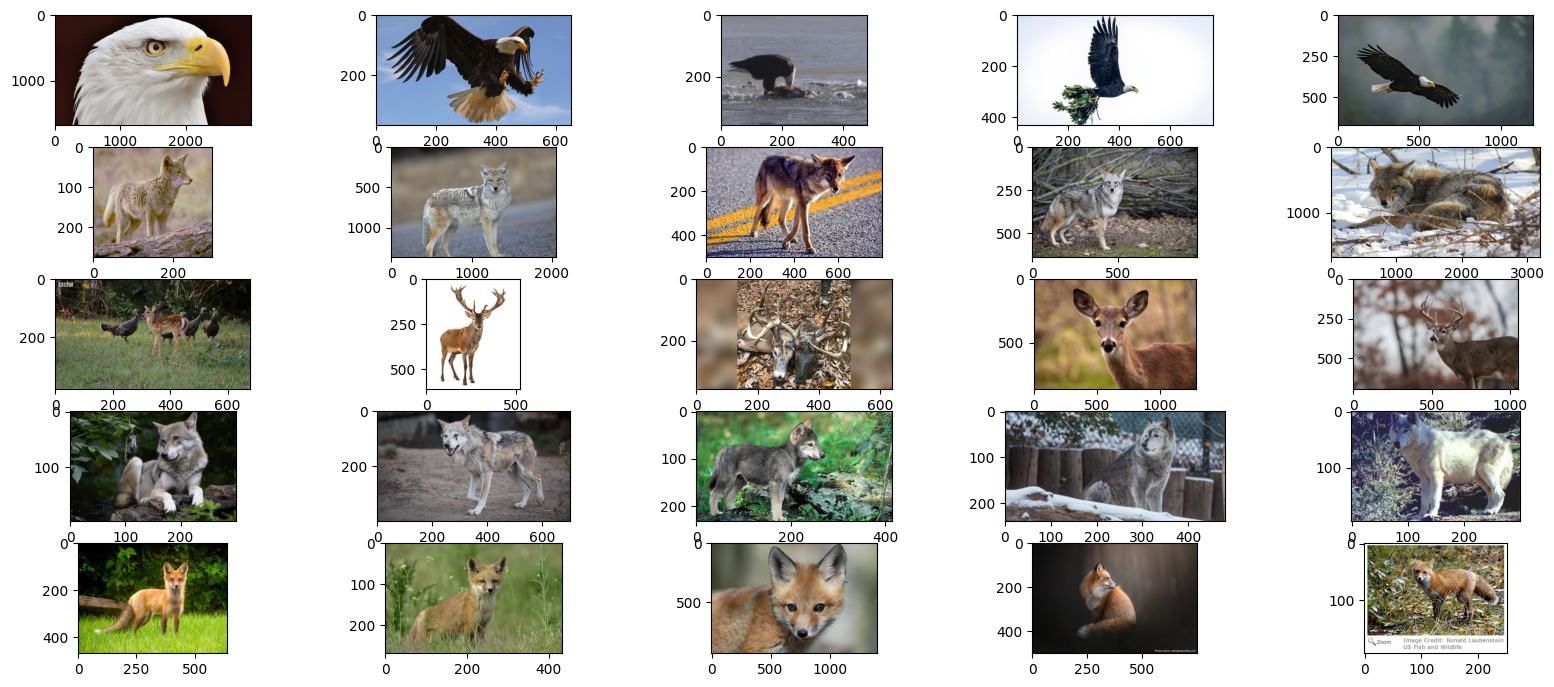

In [ ]:
images = []
for img_path in glob.glob(os.path.join(new_path,"train","bald_eagle","*.jpg"))[:5]:
    images.append(mpimg.imread(img_path))

for img_path in glob.glob(os.path.join(new_path,"train","coyote","*.jpg"))[:5]:
    images.append(mpimg.imread(img_path))

for img_path in glob.glob(os.path.join(new_path,"train","deer","*.jpg"))[:5]:
    images.append(mpimg.imread(img_path))

for img_path in glob.glob(os.path.join(new_path,"train","gray_wolf","*.jpg"))[:5]:
    images.append(mpimg.imread(img_path))

for img_path in glob.glob(os.path.join(new_path,"train","red_fox","*.jpg"))[:5]:
    images.append(mpimg.imread(img_path))

#Plot a grid of cats and Dogs
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

## Transformaciones y data augmentation

Imagenes deben ser de 224*224 para poder utilizar el modelo propuesto

In [ ]:
# Data augmentation sobre las clases que tienen más problemas

random.seed(10)
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
# channels of images
CHANNELS = images[0].shape[2]

#Compose sequence of transformations for image
transformations_train = transforms.Compose(
    [transforms.Resize(IMAGE_SIZE),
    #transforms.CenterCrop(224),
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.005),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(), # convert to tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.229, 0.224, 0.225])
  ])
transformations_test = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.229, 0.224, 0.225])
])

transformations_val = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.229, 0.224, 0.225])
])

In [ ]:
random.seed(10)
train_set = datasets.ImageFolder(os.path.join(new_path,"train"), transform = transformations_train)
test_set = datasets.ImageFolder(os.path.join(new_path,"test"), transform = transformations_test)
labels_txt = ['bald_eagle','coyote','deer','gray_wolf','red_fox']

# Put into a Dataloader using torch library
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size =32, shuffle=True)

In [ ]:
random.seed(10)
val_set = datasets.ImageFolder(os.path.join(new_path,"validation"), transform = transformations_val)
validation_loader = torch.utils.data.DataLoader(val_set, batch_size =32, shuffle=True)

In [ ]:
image_path_list= glob.glob(f"{new_path}/*/*/*.jpg")
# choose one at random

def plot_transformed_images(image_paths, transform, n=3):
    #random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow((np.asarray(f)).astype(np.uint8))
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            transformed_image = np.asarray(transformed_image)
            transformed_image = np.round(((transformed_image+1) / 2) * 255, 0)
            ax[1].imshow(np.uint8(np.clip(transformed_image, 0, 255)))
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(image_path).parent.stem}", fontsize=16)

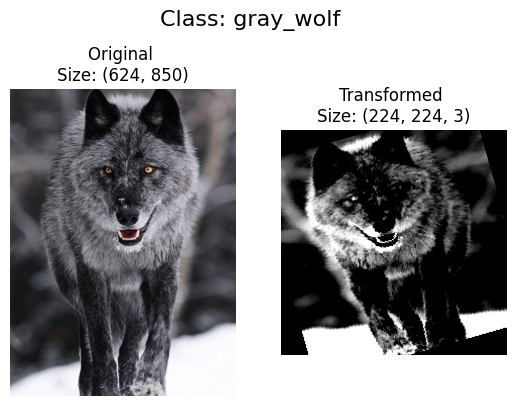

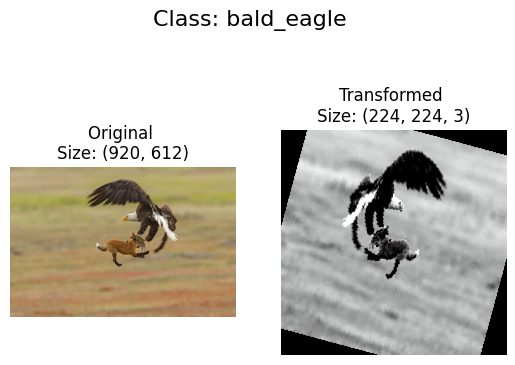

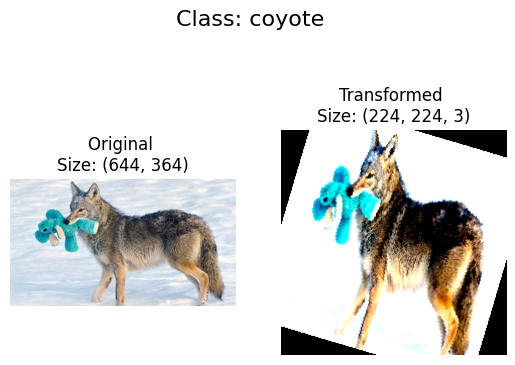

In [ ]:
plot_transformed_images(image_path_list, transform=transformations_train, n=3)

# Learn Transfer

In [ ]:
all_models = models.list_models()
classification_models = models.list_models(module=torchvision.models)

In [ ]:
classification_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

## VisionTransformer

**Attention-based neural networks such as the Vision Transformer** (ViT) have recently attained state-of-the-art results on many computer vision benchmarks. Scale is a primary ingredient in attaining excellent results, therefore, understanding a model's scaling properties is a key to designing future generations effectively. While the laws for scaling Transformer language models have been studied, it is unknown how Vision Transformers scale. To address this, we scale ViT models and data, both up and down, and characterize the relationships between error rate, data, and compute. Along the way, we refine the architecture and training of ViT, reducing memory consumption and increasing accuracy of the resulting models. As a result, we successfully train a ViT model with two billion parameters, which attains a new state-of-the-art on ImageNet of 90.45% top-1 accuracy. The model also performs well for few-shot transfer, for example, reaching 84.86% top-1 accuracy on ImageNet with only 10 examples per class.

![](https://github.com/google-research/vision_transformer/blob/main/vit_figure.png?raw=true)

[1] A. Dosovitskiy et al., “An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale”. arXiv, el 3 de junio de 2021. Consultado: el 12 de noviembre de 2023. [En línea]. Disponible en: http://arxiv.org/abs/2010.11929

In [ ]:
new_model = models.vit_b_16("DEFAULT")
print(new_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 84.5MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# Freeze model weights
for param in new_model.parameters():
    param.requires_grad = False

print(new_model.heads)

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)


Applies the $\log (\operatorname{Softmax}(x))$ function to an $\mathrm{n}$-dimensional input Tensor. The LogSoftmax formulation can be simplified as:
$$
\operatorname{LogSoftmax}\left(x_i\right)=\log \left(\frac{\exp \left(x_i\right)}{\sum_j \exp \left(x_j\right)}\right)
$$

In [ ]:
new_model.heads = nn.Sequential(
            nn.Dropout(p=0.50, inplace=True),
nn.Linear(new_model.heads.head.in_features,5),
              nn.LogSoftmax()
            )

In [ ]:
print(new_model.heads)

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=768, out_features=5, bias=True)
  (2): LogSoftmax(dim=None)
)


In [ ]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in new_model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in new_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

85,802,501 total parameters.
3,845 training parameters.


In [ ]:
def evaluate(model,data_loader):
    correct = 0
    with torch.no_grad():
            for images, labels in data_loader:
                images = images.to(device)
                labels = labels.to(device)
                model.eval()
                output = model(images)
                correct += (labels == torch.argmax(output, 1)).float().sum()
                del([images,labels])

    print('Val Accuracy: {}/{} ({:.3f}%)\n'.format(correct, len(data_loader.dataset), 100. * correct / len(data_loader.dataset)))
    return correct/len(data_loader.dataset)

## Sharpness Aware Minimization (SAM)

SAM simultaneously minimizes loss value and loss sharpness. In particular, it seeks parameters that lie in neighborhoods having uniformly low loss. SAM improves model generalization and yields SoTA performance for several datasets. Additionally, it provides robustness to label noise on par with that provided by SoTA procedures that specifically target learning with noisy labels.

![](https://github.com/davda54/sam/raw/main/img/loss_landscape.png)

*ResNet loss landscape at the end of training with and without SAM. Sharpness-aware updates lead to a significantly wider minimum, which then leads to better generalization properties.*

[2] P. Foret, A. Kleiner, y H. Mobahi, “Sharpness-Aware Minimization For Efficiently Improving Generalization”, 2021.


In [ ]:
import sys
sys.path.append("/content/sam")
from sam import sam

In [ ]:
base_optimizer = torch.optim.Adam  # define an optimizer for the "sharpness-aware" update
optimizer = sam.SAM(new_model.parameters(), base_optimizer, lr=0.01)

**The negative log likelihood loss**. It is useful to train a classification problem with $C$ classes.

If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set.

The input given through a forward call is expected to contain log-probabilities of each class. input has to be a Tensor of size either (minibatch, $C$ ) or ( minibatch, $C, d_1, d_2, \ldots, d_K$ ) with $K \geq 1$ for the $K$-dimensional case. The latter is useful for higher dimension inputs, such as computing NLL loss per-pixel for 2D images.

Obtaining log-probabilities in a neural network is easily achieved by adding a LogSoftmax layer in the last layer of your network. You may use CrossEntropyLoss instead, if you prefer not to add an extra layer.

The target that this loss expects should be a class index in the range $[0, C-1]$ where $C=$ number of classes; if ignore_index is specified, this loss also accepts this class index (this index may not necessarily be in the class range).

The unreduced (i.e. with reduction set to 'none ') loss can be described as:
$$
\ell(x, y)=L=\left\{l_1, \ldots, l_N\right\}^{\top}, \quad l_n=-w_{y_n} x_{n, y_n}, \quad w_c=\text { weight }[c] \cdot 1
$$
where $x$ is the input, $y$ is the target, $w$ is the weight, and $N$ is the batch size. If reduction is not 'none' (default 'mean'), then
$$
\ell(x, y)= \begin{cases}\sum_{n=1}^N \frac{1}{\sum_{n=1}^N w_{y_n}} l_n, & \text { if reduction }=\text { 'mean' } \\ \sum_{n=1}^N l_n, & \text { if reduction }=\text { 'sum' }\end{cases}
$$

## Fine-tunning con el modelo pre-entrenado

In [ ]:
#Define epochs, optimizer and loss function
num_epochs = 50
loss_function = nn.NLLLoss()
new_model.to(device)
max = 0
#adam_optimizer = torch.optim.Adam(new_model.parameters(), lr= 0.01)

# Train the model
total_step = len(train_loader)
print("Total Batches:",total_step)

for epoch in range(num_epochs):
    new_model.train()
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        #print(labels)
        images = images.to(device)
        labels = labels.to(device)
        outputs = new_model(images)
        print(labels.shape)
        print(outputs.shape)
        def closure():
          loss = loss_function(outputs, labels)
          loss.backward()
          return loss

        # Forward pass
        loss = loss_function(outputs, labels)
        loss.backward(retain_graph=True)
        optimizer.step(closure)
        optimizer.zero_grad()
        train_loss += loss.item()* labels.size(0)

    #After each epoch print Train loss and validation loss + accuracy
    print ('Epoch [{}/{}], Training Loss: {:.4f}' .format(epoch+1, num_epochs, loss.item()))

    #After each epoch evaluate model
    val_acc = evaluate(new_model,test_loader)
    #if val_acc.item() > max:
    #  max = val_acc.item()
    #  torch.save(new_model.state_dict(), "/content/drive/MyDrive/ViTSAM/Best/model.pt")
    #  print('Files saved')

NameError: ignored

In [ ]:
# save the model weights and its configuration file
torch.save(new_model.state_dict(), "/content/drive/MyDrive/ViTSAM/model.pt")
print('Files saved')

Files saved


## Carga del mejor modelo

In [ ]:
model = models.vit_b_16("DEFAULT")
weights = torch.load( "/content/drive/MyDrive/ViTSAM/Best/model.pt")
model.heads = nn.Sequential(
    nn.Dropout(p=0.50, inplace=True),
    nn.Linear(model.heads.head.in_features,5),
    nn.LogSoftmax())
model.load_state_dict(weights)
model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

# Predicción sobre conjunto de validación

In [ ]:
# Precisión sobre conjunto de validación
model.to(device)
evaluate(model,validation_loader)

Val Accuracy: 726.0/747 (97.189%)



tensor(0.9719, device='cuda:0')

In [ ]:
def evaluate_valdata(model, loader):
    preds = []
    true_labels = []
    with torch.no_grad():
        images, labels = next(iter(loader))
        images = images.to(device)
        #images = images[:3, :, :]
        labels = labels.to(device)
        model.eval()
        output = model(images)

        predicted = torch.argmax(output, 1)
        preds.append(predicted.int())
        true_labels.append(labels)
    return images, true_labels, preds

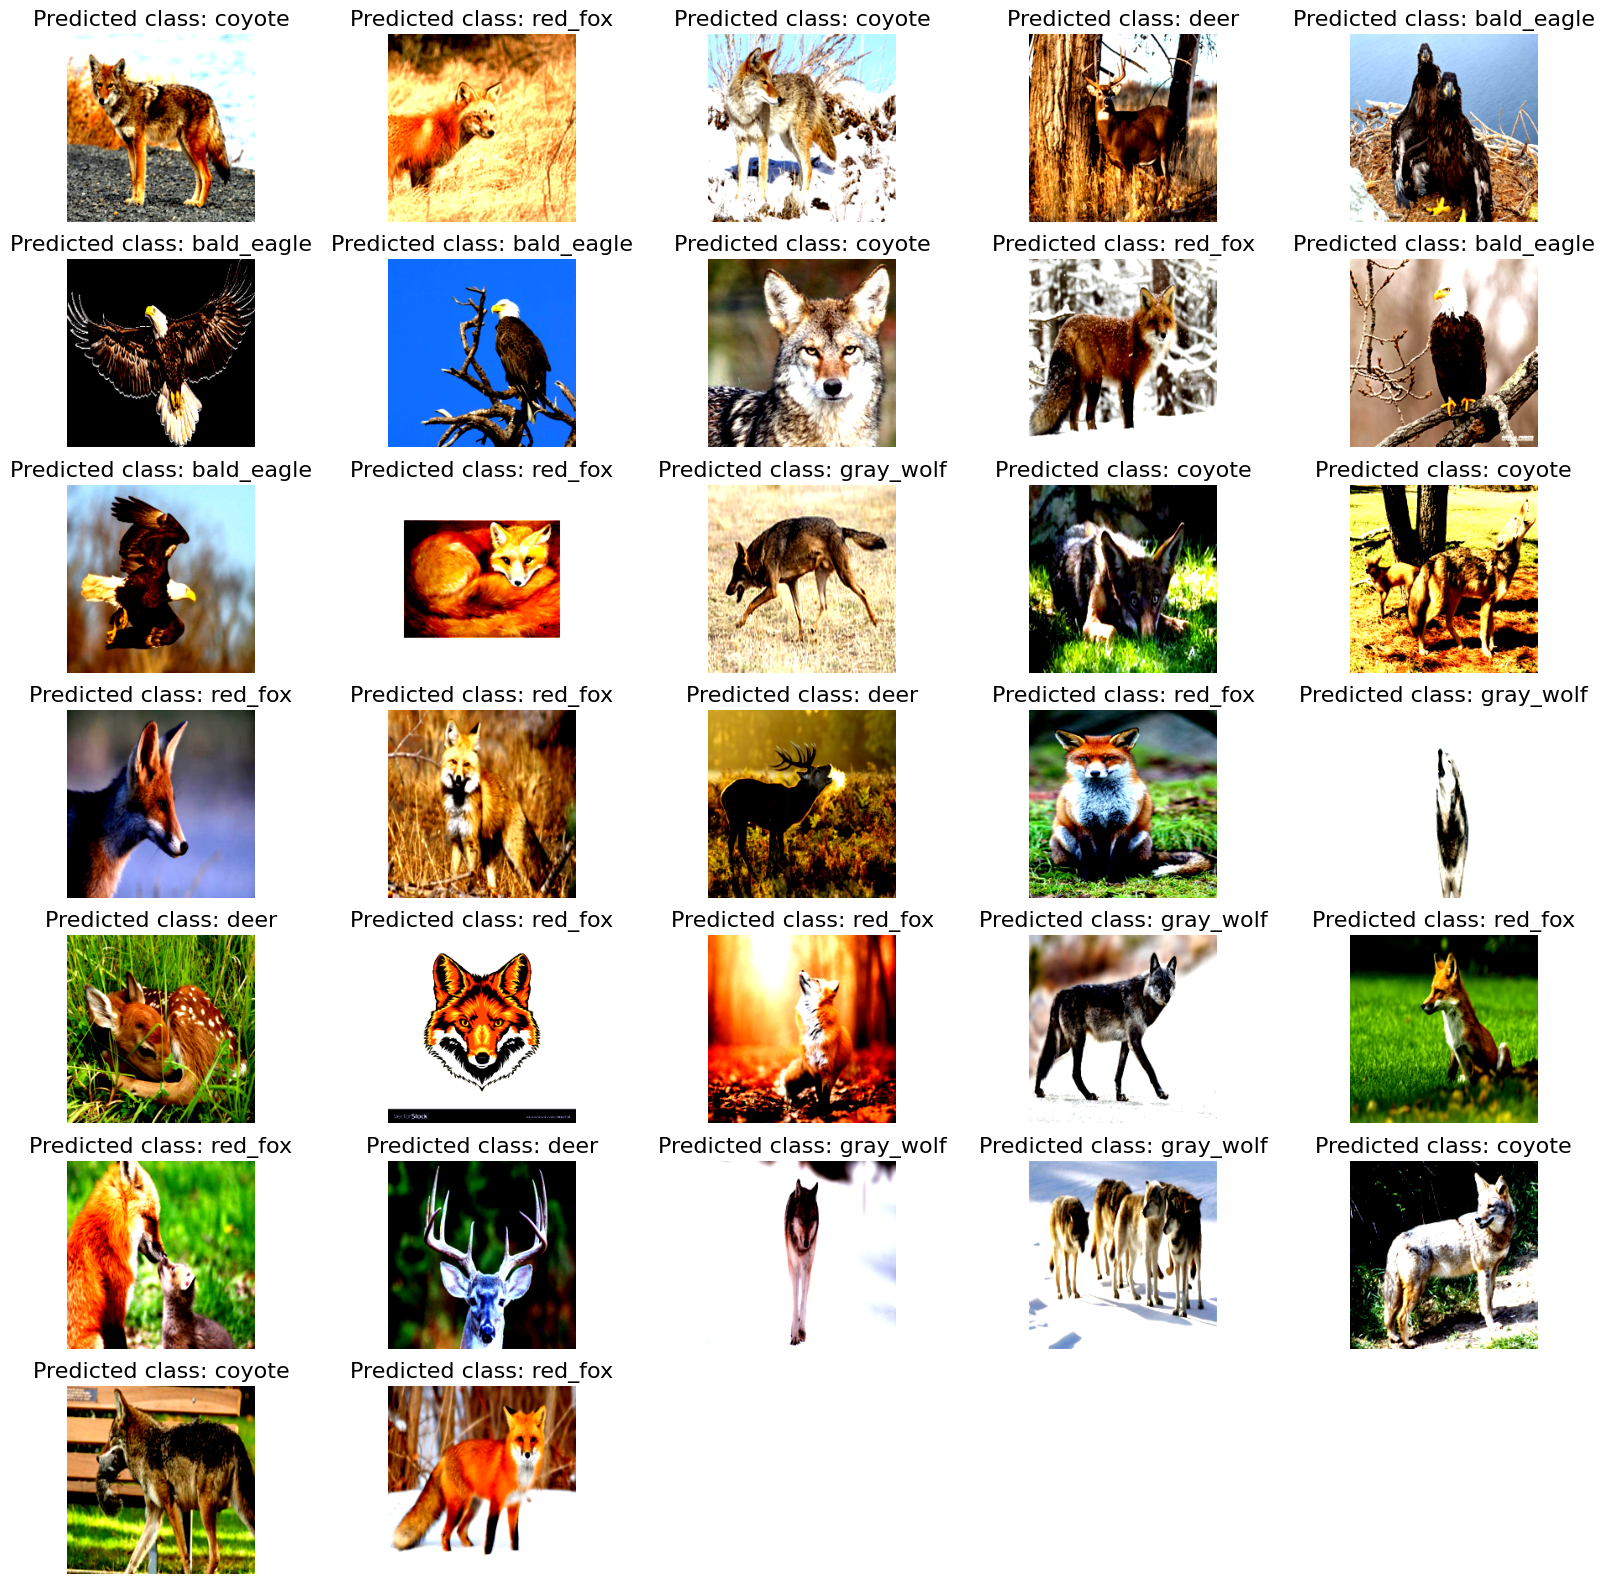

In [ ]:
from itertools import chain

im, _, preds = evaluate_valdata(model,validation_loader)
preds = list(chain.from_iterable(preds)) #vectorizar las etiquetas devueltas
pred_lab = []
pred_imgs = []
for i, lab in enumerate(preds):
    val = lab.cpu().numpy().astype(int)
    pred_lab.append(labels_txt[val])
    temp=im[i].permute(1, 2, 0)
    val_image = temp.cpu().numpy()
    pred_imgs.append(np.round(((val_image+1) / 2) * 255, 0))

# visualizar las predicciones
plt.figure(figsize=(20,20))
columns = 5
for i, image in enumerate(pred_imgs):
    plt.subplot(int(len(pred_imgs) / columns + 1), columns, i + 1)
    plt.axis("off")
    plt.title(f"Predicted class: {pred_lab[i]}", fontsize=16)
    plt.imshow(np.uint8(np.clip(image, 0, 255)));

    #plt.imshow(image)

# Guardado y carga del modelo

In [ ]:
def eval_test(data_loader):
    model = models.vit_b_16("DEFAULT")
    weights = torch.load( "/content/drive/MyDrive/ViTSAM/Best/model.pt")
    model.heads = nn.Sequential(
      nn.Dropout(p=0.50, inplace=True),
      nn.Linear(model.heads.head.in_features,5),
      nn.LogSoftmax())
    model.load_state_dict(weights)
    model.to(device)
    model.eval()
    correct = 0
    true_labels = []
    predictions = []
    with torch.no_grad():
      for images, labels in data_loader:
          images = images.to(device)
          labels = labels.to(device)
          output = model(images)
          predictions.append(torch.argmax(output, 1).cpu().numpy().astype(int))
          true_labels.append(labels.cpu().numpy().astype(int))
          del([images,labels])
    return np.concatenate(true_labels), np.concatenate(predictions)

In [ ]:
true_labels, predictions = eval_test(validation_loader)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions, target_names=labels_txt))

              precision    recall  f1-score   support

  bald_eagle       0.99      1.00      1.00       149
      coyote       0.95      0.94      0.95       147
        deer       0.99      0.99      0.99       153
   gray_wolf       0.93      0.96      0.95       146
     red_fox       0.99      0.97      0.98       152

    accuracy                           0.97       747
   macro avg       0.97      0.97      0.97       747
weighted avg       0.97      0.97      0.97       747



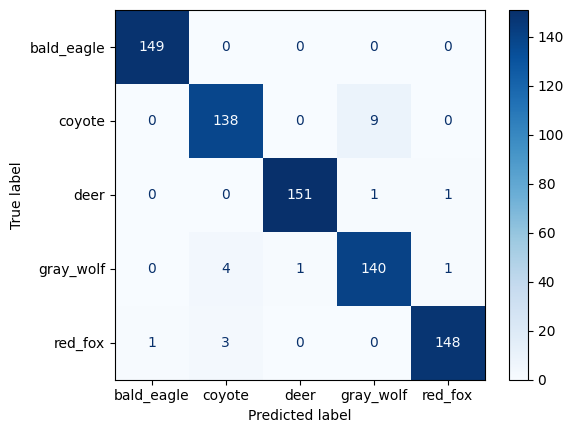

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels=labels_txt)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
images_proy = []

with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    out = model.conv_proj(images)
    out = model.encoder.dropout(out)
    out = model.encoder.layers(out.reshape(-1,196,768))
    images_proy.append(out.to("cpu"))

In [ ]:
images_proy_ = np.concatenate(images_proy, axis=0)
images_proy_.shape

(374, 196, 768)

In [ ]:
images_proy_2d = images_proy_.reshape(374,-1)
images_proy_2d.shape

(374, 150528)

In [ ]:
images_proy_2d

array([[-0.24202779, -0.17779042,  0.5562472 , ...,  0.35212123,
        -0.618361  , -0.51898134],
       [ 0.16695487, -0.3343358 , -0.15518114, ..., -0.76401997,
        -0.62810856, -0.2146008 ],
       [-0.00340214, -0.53049105, -0.08069444, ..., -0.19905418,
        -1.3195467 , -0.21763334],
       ...,
       [ 0.56763506,  0.17437133,  0.3812546 , ..., -0.09461525,
        -0.70993024, -0.58237994],
       [-0.09589815,  0.05916838,  0.49139798, ...,  0.11089073,
        -0.42632163, -0.21274921],
       [ 0.02641135,  0.39914668,  0.6149758 , ..., -0.5669757 ,
        -0.5051741 , -0.8337945 ]], dtype=float32)

In [ ]:
# Visualización para dos componentes
from sklearn.decomposition import PCA
pca = PCA()
principal_components = pca.fit_transform(images_proy_2d)
principal_components.shape

(374, 374)

In [ ]:
# Data augmentation sobre las clases que tienen más problemas

random.seed(10)
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

#Compose sequence of transformations for image

transformations_test = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    #transforms.CenterCrop(224),
    transforms.ToTensor()])

In [ ]:
test_set_or = datasets.ImageFolder(os.path.join(new_path,"test"), transform=transformations_test)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


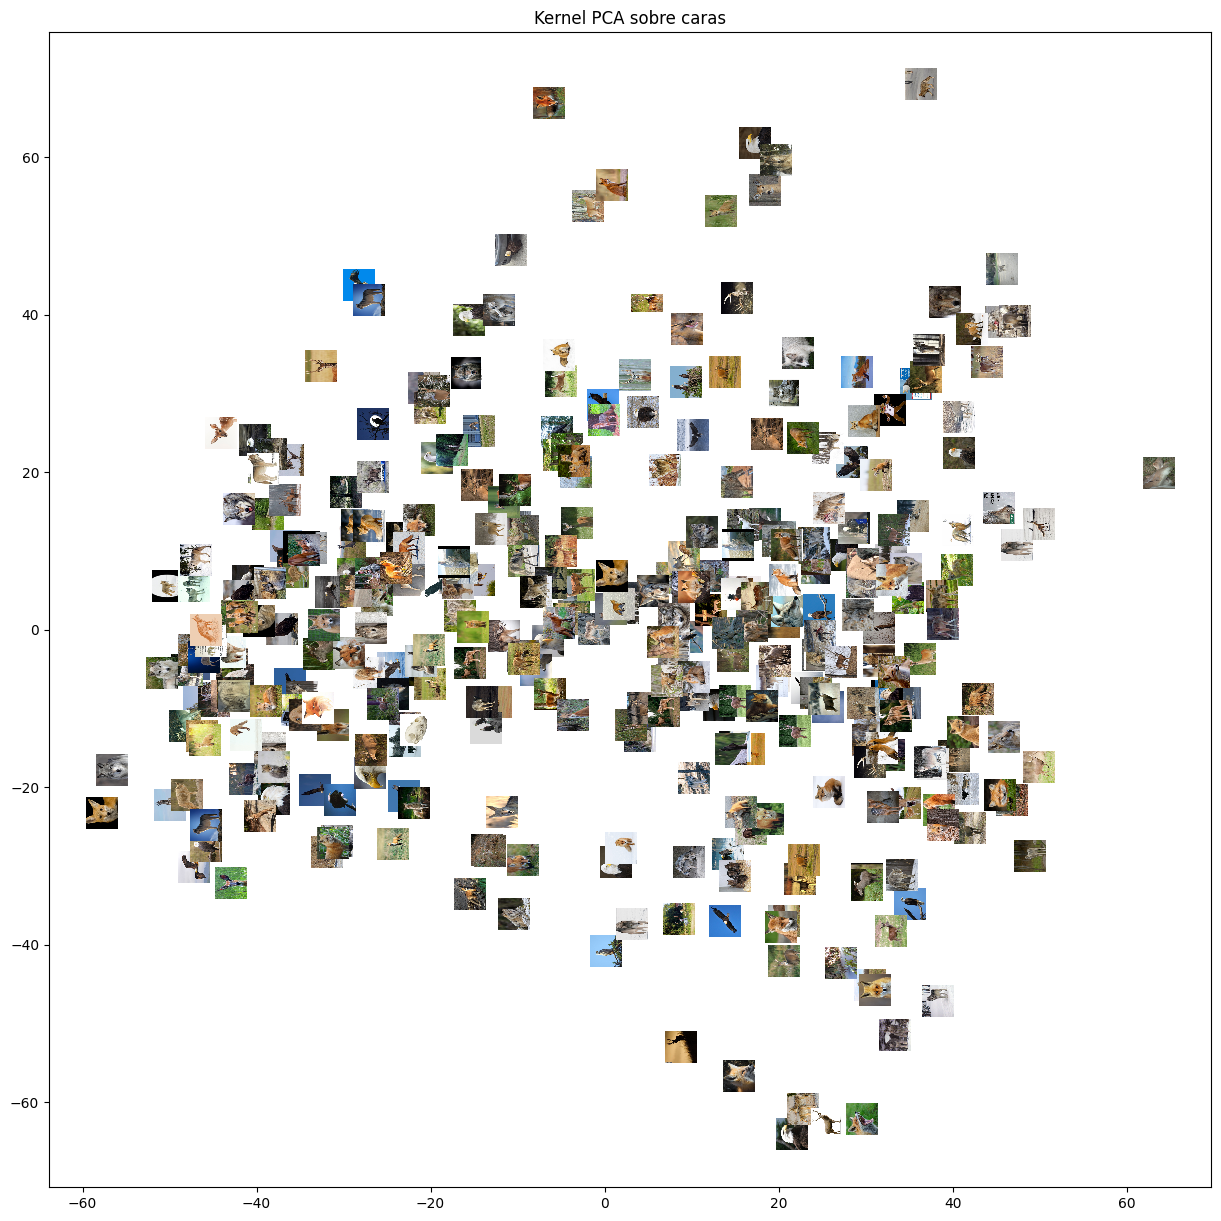

In [ ]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
images = []
for i in range(len(test_set_or)):
    animal = np.transpose(np.array(test_set_or[i][0]))
    #image = OffsetImage((animal * 255).astype(np.uint8), zoom=0.1, cmap='gray')
    image = OffsetImage(animal, zoom=0.1, cmap='gray')
    images.append(image)

# Graficar los puntos y agregar las imágenes correspondientes
fig, ax = plt.subplots(figsize=(15, 15))
for i in range(len(principal_components)):
    xi, yi = principal_components[:,0:2][i]
    ab = AnnotationBbox(images[i], (xi, yi), xycoords='data', frameon=False)
    ax.add_artist(ab)
    plt.scatter(xi, yi, s=10)
plt.title("Kernel PCA sobre caras")
plt.show()

In [ ]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(kernel='cosine', n_components=2)
principal_components_kpca = kpca.fit_transform(images_proy_2d)

principal_components_kpca_2d = pd.DataFrame(principal_components_kpca[:,0:2])
principal_components_kpca_2d = np.array(principal_components_kpca_2d)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


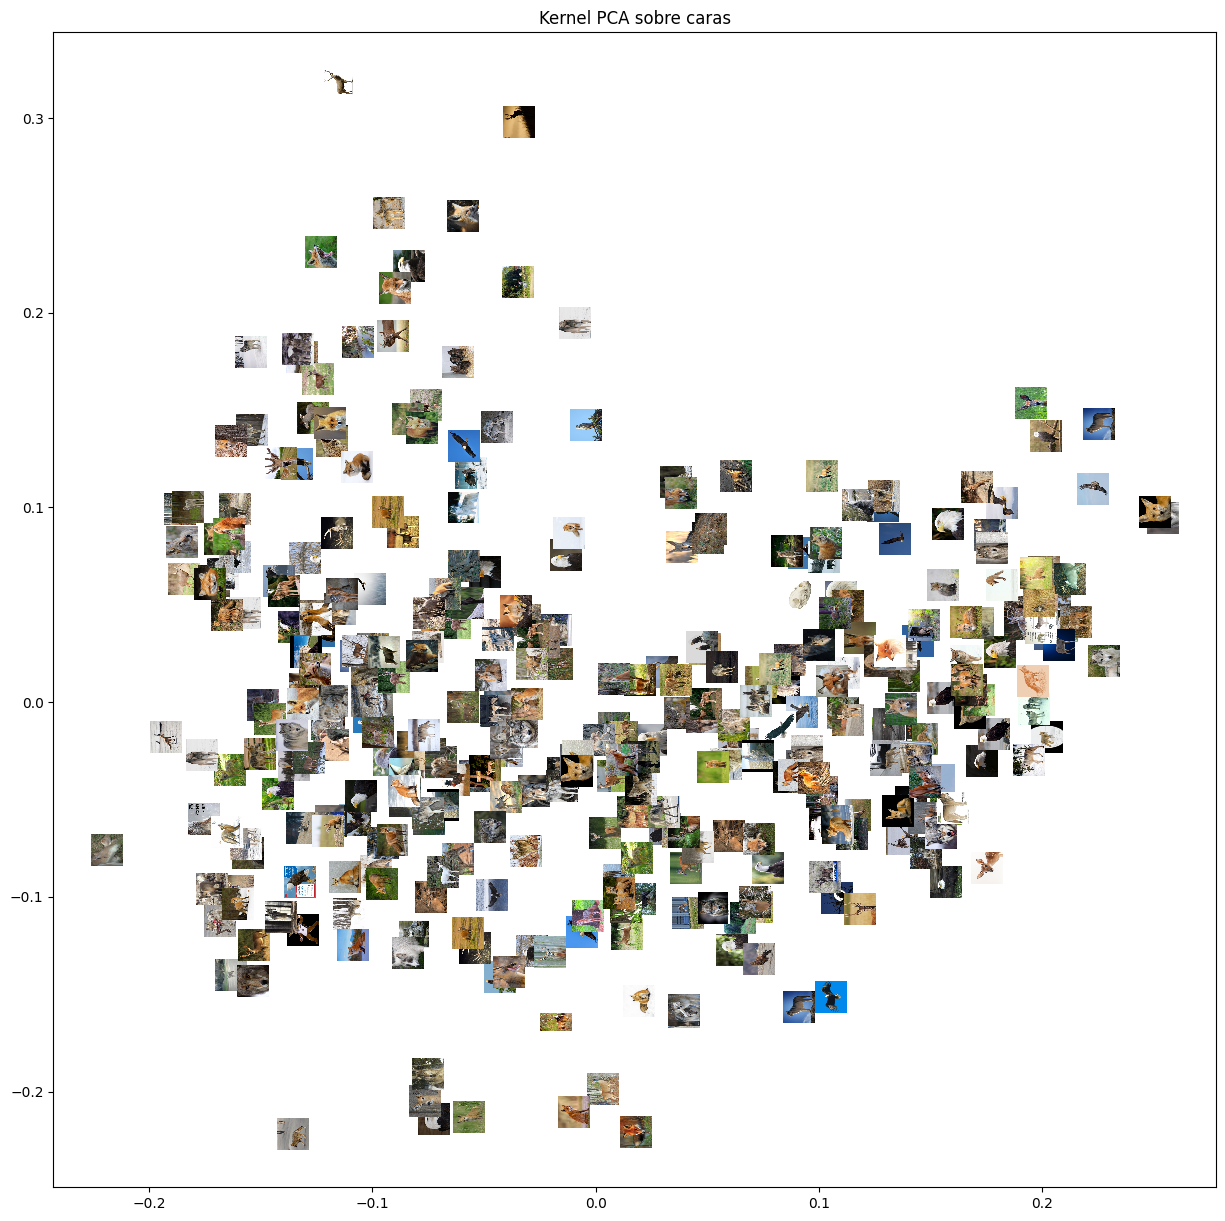

In [ ]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
images = []
for i in range(len(test_set_or)):
    animal = np.transpose(np.array(test_set_or[i][0]))
    #image = OffsetImage((animal * 255).astype(np.uint8), zoom=0.1, cmap='gray')
    image = OffsetImage(animal, zoom=0.1, cmap='gray')
    images.append(image)

# Graficar los puntos y agregar las imágenes correspondientes
fig, ax = plt.subplots(figsize=(15, 15))
for i in range(len(principal_components_kpca_2d)):
    xi, yi = principal_components_kpca_2d[i]
    ab = AnnotationBbox(images[i], (xi, yi), xycoords='data', frameon=False)
    ax.add_artist(ab)
    plt.scatter(xi, yi, s=10)
plt.title("Kernel PCA sobre caras")
plt.show()

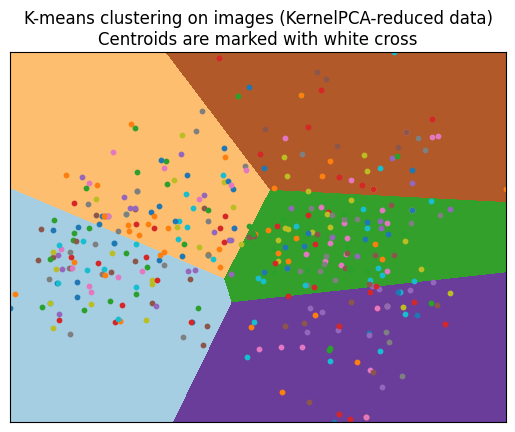

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

data = images_proy_2d

#kpca = KernelPCA(kernel='cosine', n_components=2)
#reduced_data = kpca.fit_transform(data)
reduced_data = PCA(n_components=2).fit_transform(data)

kmeans = KMeans(init="k-means++", n_clusters=5, n_init=4)
kmeans.fit(reduced_data.astype('double'))

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min(), reduced_data[:, 0].max()
y_min, y_max = reduced_data[:, 1].min(), reduced_data[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

#plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
for i in range(len(reduced_data)):
    xi, yi = reduced_data[i]
    ab = AnnotationBbox(images[i], (xi, yi), xycoords='data', frameon=False)
    ax.add_artist(ab)
    plt.scatter(xi, yi, s=10)


# Plot the centroids as a white X
#centroids = kmeans.cluster_centers_
#plt.scatter(
#    centroids[:, 0],
#    centroids[:, 1],
#    marker="x",
#    s=169,
#    linewidths=3,
#    color="w",
#    zorder=10,
#)
plt.title(
    "K-means clustering on images (KernelPCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
tsne = manifold.TSNE(n_components=2, random_state=0, perplexity=1, early_exaggeration = 12)
trans_data = tsne.fit_transform(images_proy_2d)

In [ ]:
trans_data_2d = pd.DataFrame(trans_data[:,0:2])
trans_data_2d = np.array(trans_data_2d)

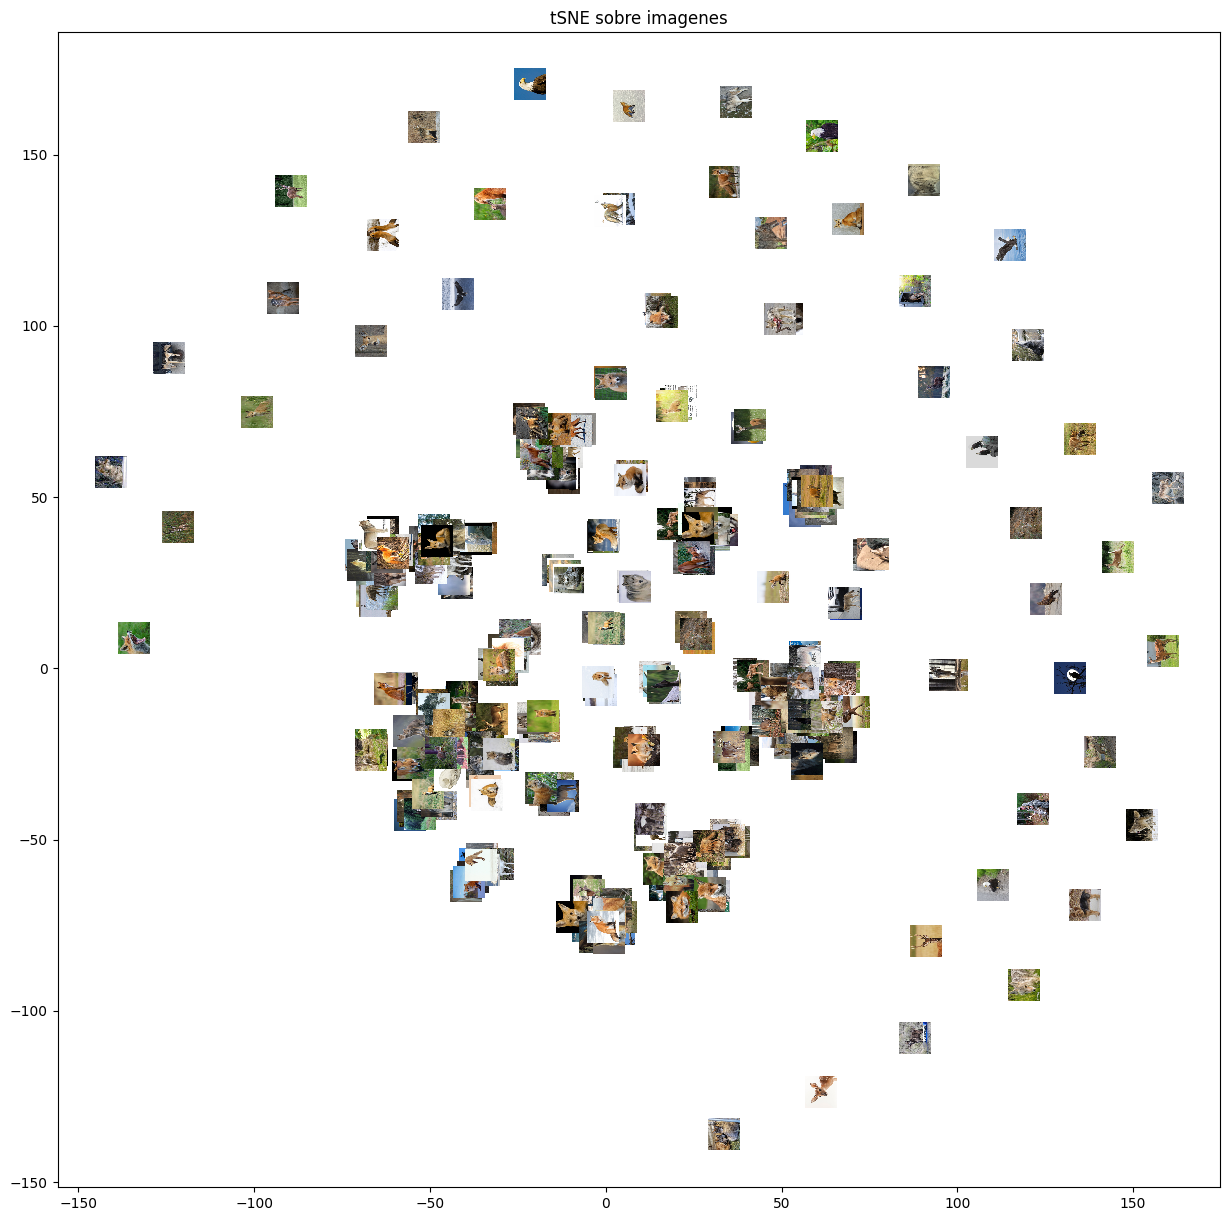

In [ ]:
images = []
for i in range(len(test_set_or)):
    animal = np.transpose(np.array(test_set_or[i][0]))
    #image = OffsetImage((animal * 255).astype(np.uint8), zoom=0.1, cmap='gray')
    image = OffsetImage(animal, zoom=0.1, cmap='gray')
    images.append(image)

# Graficar los puntos y agregar las imágenes correspondientes
fig, ax = plt.subplots(figsize=(15, 15))
for i in range(len(trans_data)):
    xi, yi = trans_data[i]
    ab = AnnotationBbox(images[i], (xi, yi), xycoords='data', frameon=False)
    ax.add_artist(ab)
    plt.scatter(xi, yi, s=10)
plt.title("tSNE sobre imagenes")
plt.show()
#plt.scatter(trans_data[0], trans_data[1], cmap=plt.cm.rainbow)